#### — Скачайте текст войны и мир (ссылка на github и гугл диск). Очистите его, оставив только русские буквы и символы пробела. Постройте матрицу переходных вероятностей. 

In [1]:
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline
sns.set()

In [118]:
text_full = ''
for i in range(1, 5):
    with open(f'tom_{i}.txt', 'r') as f:
        text = f.read().lower()
    text = re.sub('\s+', ' ', text)
    text = re.sub('[^а-я ]','', text)
    text = re.sub('\s+', ' ', text)
    text_full += ' ' + text
print('')

In [38]:
from collections import Counter

In [39]:
RUSSIAN = 'абвгдежзийклмнопрстуфхцчшщъыьэюя'
POS = {l: i for i, l in enumerate(RUSSIAN)}
probabilities = np.zeros((len(RUSSIAN), len(RUSSIAN)))

In [40]:
for pair, count in Counter(zip(text[:-1], text[1:])).items():
    if ' ' not in pair:
        probabilities[POS[pair[0]], POS[pair[1]]] = count

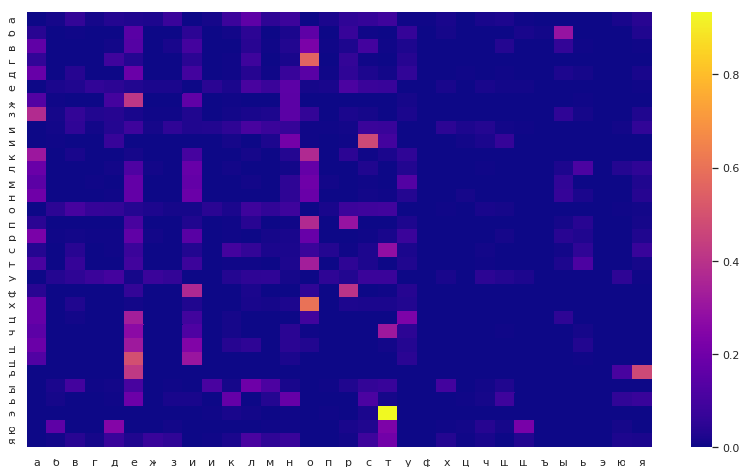

In [41]:
probabilities = (probabilities / probabilities.sum(axis=1)[:, None])

df = pd.DataFrame(probabilities, index=(c for c in RUSSIAN), columns=(c for c in RUSSIAN))

plt.figure(figsize=(14,8))
sns.heatmap(df, cmap='plasma')
plt.show()

#### Посчитайте вероятность встретить строку из 4-х символов, которая начинается п, а кончается на р; 

In [46]:
start = POS['п']
end = POS['р']
prior = 1 / len(RUSSIAN)
prob = 0
for l1 in RUSSIAN:
    for l2 in RUSSIAN:
        prob += prior * (probabilities[start, POS[l1]] * 
                         probabilities[POS[l1], POS[l2]] * 
                         probabilities[POS[l2], end])

In [48]:
print(f'Вероятность встретить строку из 4-х символов, которая начинается п, а кончается на р = {prob}')

Вероятность встретить строку из 4-х символов, которая начинается п, а кончается на р = 0.001209451768604803


#### Используя матрицу переходных вероятностей сгенерируйте слово, начинающееся с буквы “Б” и имеющее длину 8-мь символов.

In [167]:
s = 'б'
length = 8
for i in range(length):
    index = POS[s[i]]
    next_char = np.random.choice(list(RUSSIAN), p=probabilities[index])
    s += next_char

print(f'Сгенерированное слово: {s}')

Сгенерированное слово: брилормел


#### — Выберите ряд (файл во вложении) и оцените его через HMM. Попробуйте “построить” (через среднее каждой компоненты) наивный прогноз ряда.

In [114]:
df = pd.read_csv('numbers-on-unemployment-benefits.csv')

In [115]:
df.head()

,Month,Numbers on Unemployment Benefits in Australia: monthly Jan 1956 ? Jul 1992
0,1956-01,4742.0
1,1956-02,6128.0
2,1956-03,6494.0
3,1956-04,5379.0
4,1956-05,6011.0


In [116]:
df.columns = ['Month', 'Unemployment Benefits']

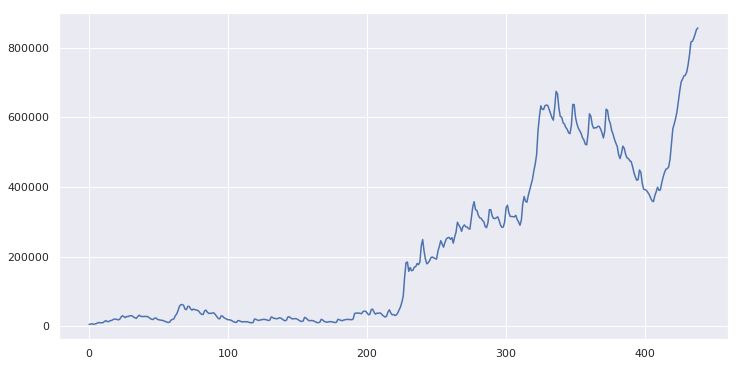

In [117]:
plt.figure(figsize=(12,6))
plt.plot(df['Unemployment Benefits'])

In [118]:
df.isna().sum()

Month                    0
Unemployment Benefits    1
dtype: int64

In [119]:
df.dropna(inplace=True)

In [120]:
from hmmlearn.hmm import GaussianHMM
from tqdm import tqdm_notebook

In [121]:
series = df['Unemployment Benefits'].values.reshape(-1, 1)

In [163]:
results = {}
for n in tqdm_notebook(range(1, 21)):
    model = GaussianHMM(n_components=n,
                        covariance_type="diag",
                        n_iter=1500)
    model.fit(series)
    results[n] = model.score(series)

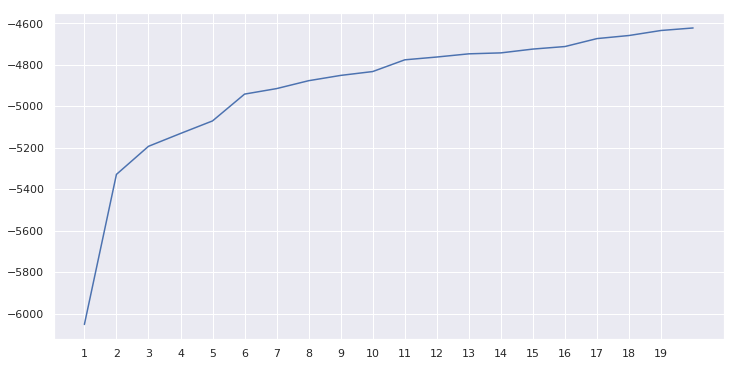

In [164]:
fig = plt.figure(figsize=(12,6))
ax = plt.plot(results.keys(), results.values())
ticks = plt.xticks(range(1, 20))

Примем n = 6 

In [165]:
n_opt = 6

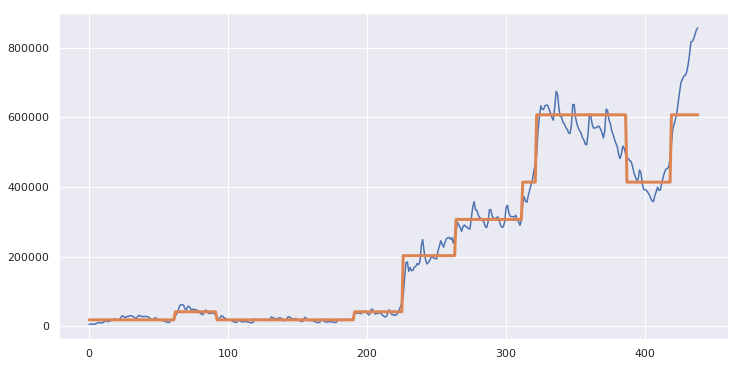

In [181]:
means_dct = {}
model = GaussianHMM(n_components=n_opt,
                        covariance_type="diag",
                        n_iter=1500)
model.fit(series)
labels = model.predict(series)
means = np.zeros_like(series)
for i in range(model.n_components):
    means[labels == i] = model.means_[i]
    means_dct[i] = model.means_[i]
    
plt.figure(figsize=(12, 6))
plt.plot(series)
plt.plot(means, linewidth=3)

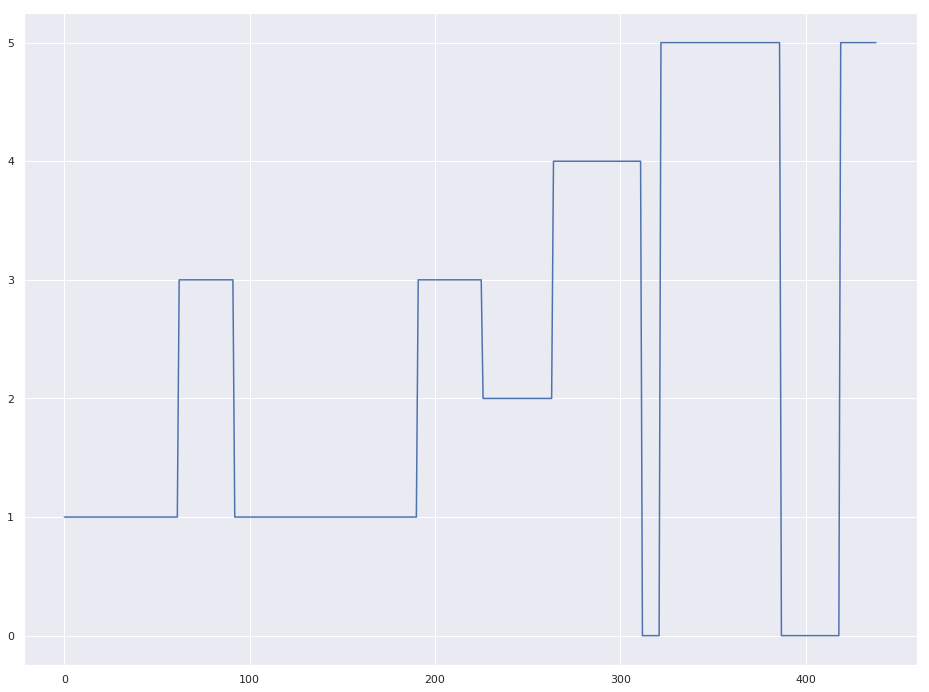

In [182]:
plt.figure(figsize=(16,12))
plt.plot(labels)
plt.show()

In [183]:
means_dct

{0: array([413614.72850876]),
 1: array([18030.32204405]),
 2: array([202459.77046432]),
 3: array([41230.29056969]),
 4: array([306496.86903421]),
 5: array([606970.04231232])}

In [184]:
model.transmat_[labels[-1]]

array([1.18160421e-002, 0.00000000e+000, 2.55082729e-223, 0.00000000e+000,
       9.47355905e-128, 9.88183958e-001])

In [206]:
# количество предсказаний
n_pred = 32
cur_label = labels[-n_pred]
label_pred = []
# предсказания
predictions = []

In [207]:
for i in range(n_pred):
    cur_label = np.random.choice(6, p = model.transmat_[cur_label])
    label_pred.append(cur_label)
    predictions.append(means_dct[cur_label])

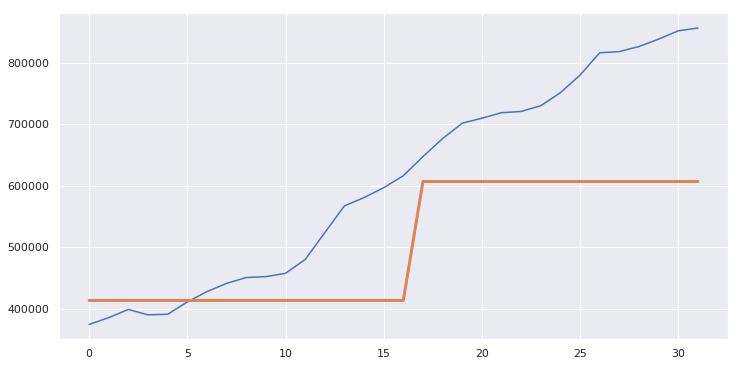

In [208]:
plt.figure(figsize=(12, 6))
plt.plot(series[-n_pred:])
plt.plot(predictions, linewidth=3)